## Chapter 3 [Imaging](Ch3-Imaging.ipynb)


<hr style="height:1px;border-top:4px solid #FF8200" />

# Image Processing


part of 

## [Analysis of Transmission Electron Microscope Data](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)



by Gerd Duscher, 2019

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes
part of 



## First we import all relvant libraries

In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
%pylab --no-import-all notebook

# our blob detectors from the scipy image package
from skimage.feature import blob_dog, blob_log, blob_doh
# Multidimensional Image library
import scipy.ndimage as ndimage

import time
# Import libraries from the book
import pyTEMlib
import pyTEMlib.file_tools as ft          # File input/ output library
import pyTEM.TEMlib.KinsCat as ks         # Kinematic sCattering Library


# The file format we use is pyUSID
import pyUSID as usid
import h5py as hf5

# it is a good idea to show the version numbers at this point for archiving reasons.
print('pyUSID version: ',usid.__version__)
print('pyTEM version: ',pyTEMlib.__version__)

%gui qt

Populating the interactive namespace from numpy and matplotlib
windows
Using KinsCat library version  0.5  by G.Duscher
Symmetry functions of spglib enabled
pyUSID version:  0.0.4
pyTEM version:  0.5.2019


### Load an atomic resolution image:
As an example we will use **p1-hr3-ZnOonGraphite.dm3** in the TEMdata directory

<IPython.core.display.Javascript object>


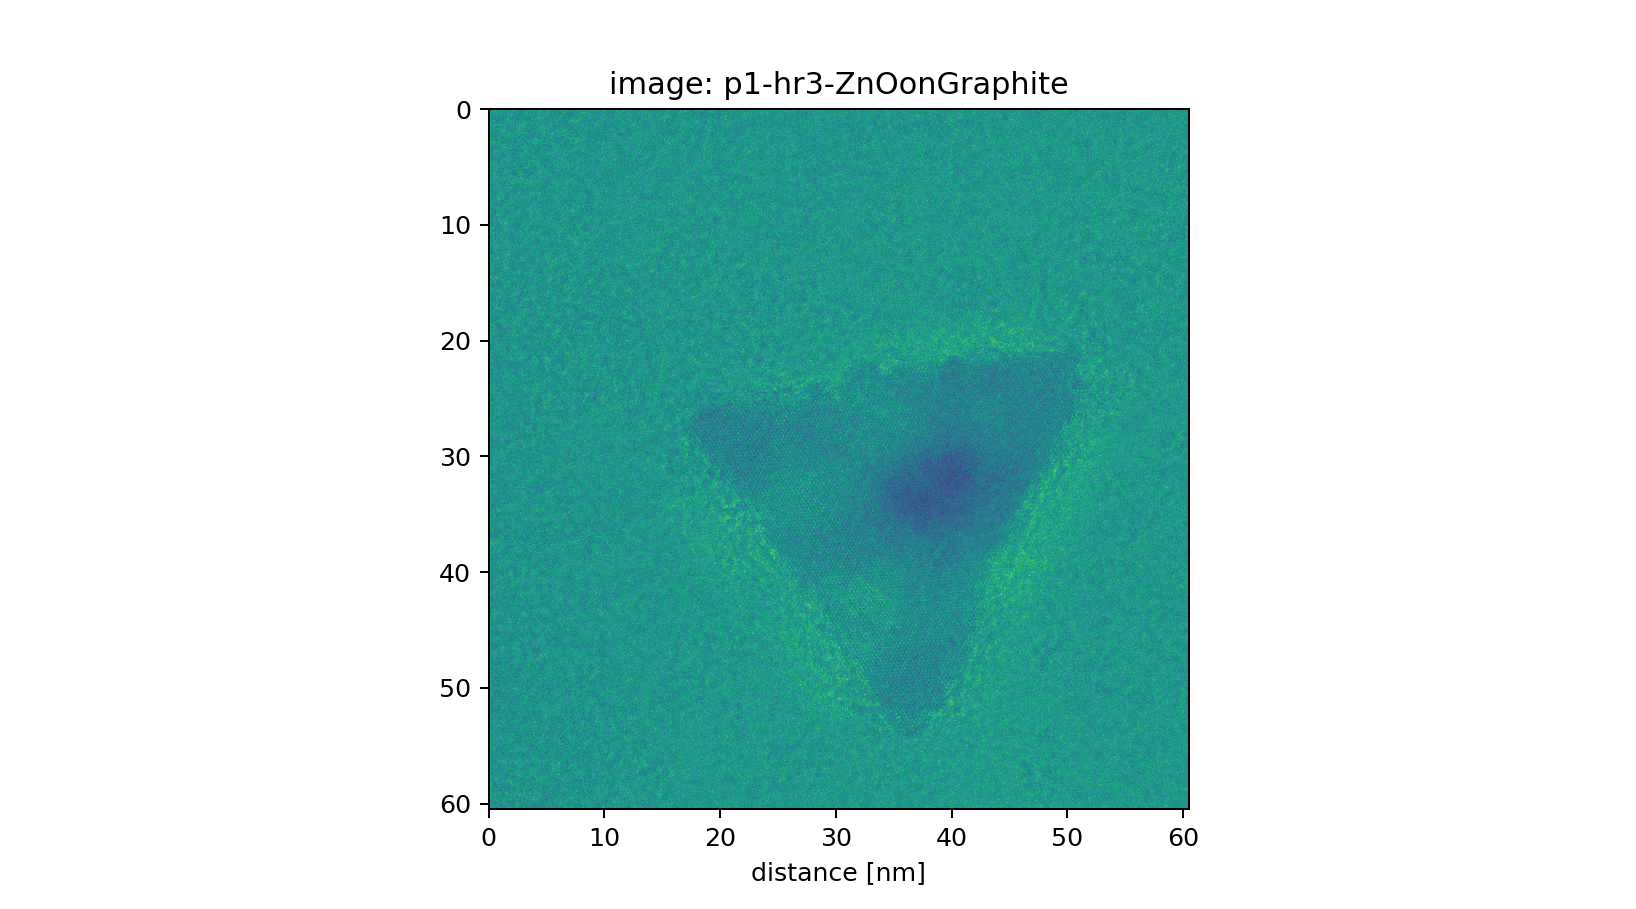

In [5]:
# Load file
h5_file.close()
h5_file = ft.h5open_file()#os.path.join(current_directory,filename))
current_channel = h5_file['Measurement_000/Channel_000']
fig = plt.figure(figsize=(9,5))
ft.plt_pyUSID(current_channel, plt.gca())

out_tags = {}
clock  = time.localtime()

date = f'{clock[0]}_{clock[1]:g}_{clock[2]}'
out_tags['analysis_log'] ={}
out_tags['analysis_log'][date]={}
log = out_tags['analysis_log'][date]

## Fourier Transform of Image

16.934295348472048 16.934295348472048


<IPython.core.display.Javascript object>


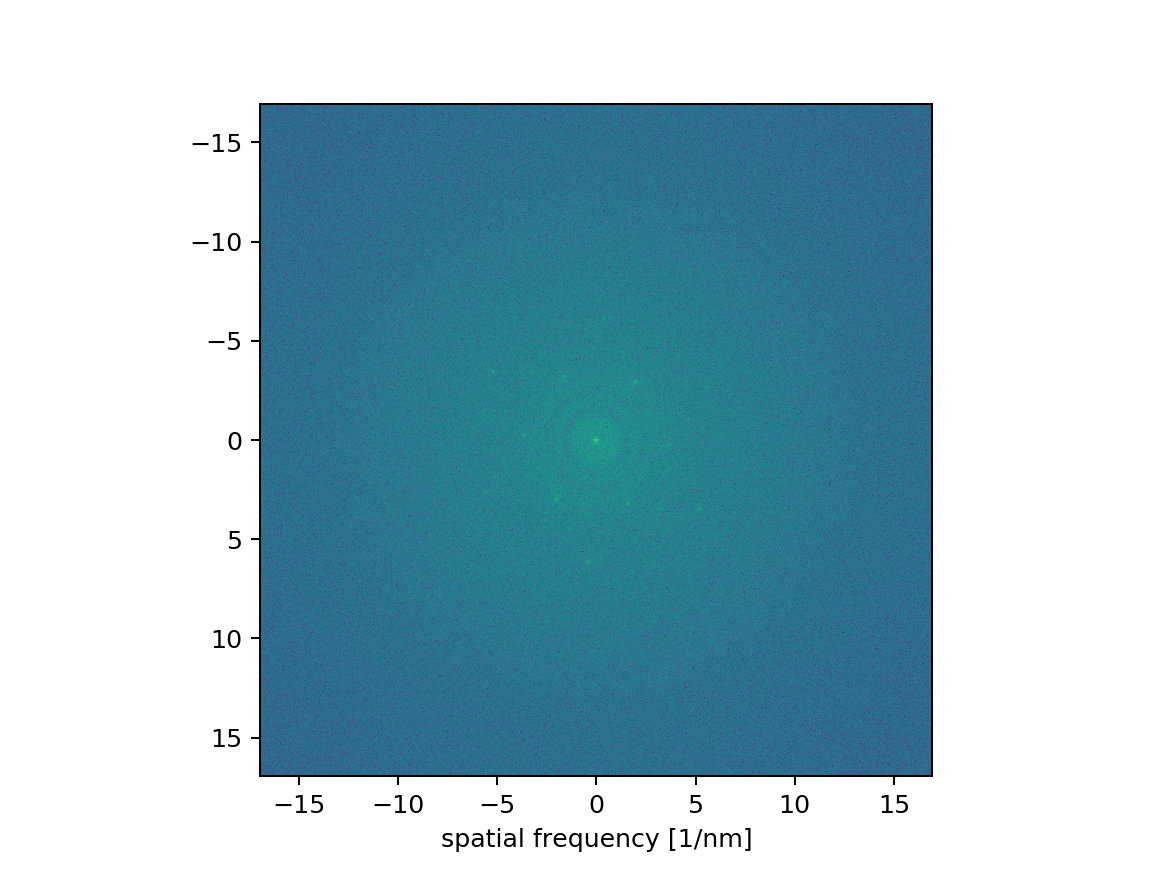

In [6]:
if current_channel['data_type'][()] == 'image':
    ## spatial data
    tags = dict(current_channel.attrs)
    basename = current_channel['title'][()]
    
    sizeX = current_channel['spatial_size_x'][()]
    sizeY = current_channel['spatial_size_y'][()]
    scaleX = current_channel['spatial_scale_x'][()]
    scaleY = current_channel['spatial_scale_y'][()]
    basename = current_channel['title'][()]

    FOV_x = sizeX*scaleX
    FOV_y = sizeY*scaleY
    
    data = np.reshape(current_channel['Raw_Data'][:,0],(sizeX,sizeY))


image = data- data.min()
fft_mag = (np.abs((np.fft.fftshift(np.fft.fft2(image)))))

## pixel_size in recipical space
rec_scale_x = 1/FOV_x  
rec_scale_y = 1/FOV_y 

## Field of View (FOV) in recipical space please note: rec_FOV_x = 1/(scaleX*2)
rec_FOV_x = rec_scale_x * sizeX /2.
rec_FOV_y = rec_scale_y * sizeY /2.
print(rec_FOV_x , 1/(scaleX*2))


## Field ofView (FOV) in recipical space
rec_extend = (-rec_FOV_x,rec_FOV_x,rec_FOV_y,-rec_FOV_y)



fig = plt.figure()
plt.imshow(np.log2(1+fft_mag).T, extent=rec_extend, origin = 'upper'); 
plt.xlabel('spatial frequency [1/nm]');


## Shorter

dict_keys(['acceleration_voltage', 'camera_length', 'image_type', 'time_last_modified', 'data_type', 'data', 'image_size_x', 'image_size_y', 'pixel_size_x', 'pixel_size_y', 'FOV_x', 'FOV_y', 'extent', 'units'])


<IPython.core.display.Javascript object>


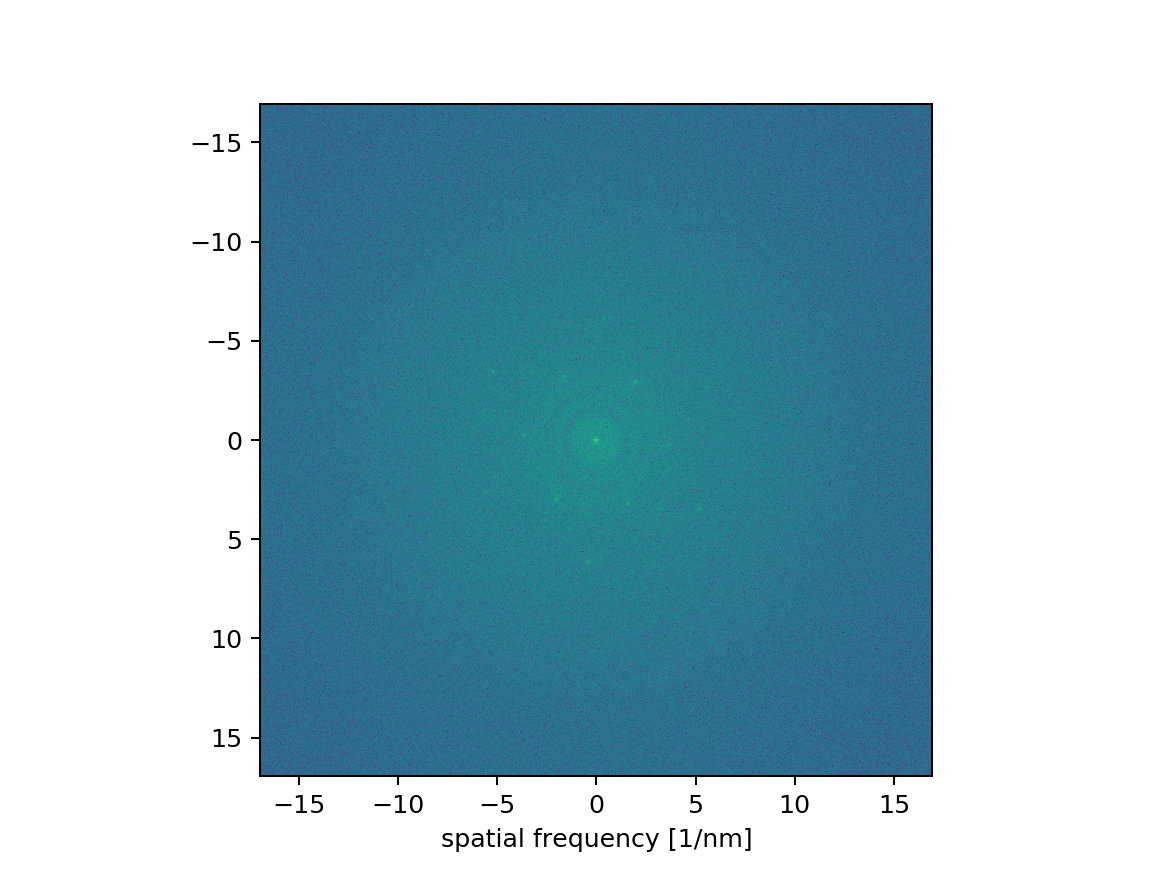

In [31]:
tags = ft.get_dictionary_from_pyUSID(current_channel)
print(tags.keys())

image = tags['data']- tags['data'].min()
fft_mag = (np.abs((np.fft.fftshift(np.fft.fft2(image)))))


## Field of View (FOV) in recipical space please note: rec_FOV_x = 1/(scaleX*2)
rec_FOV_x = 1/tags['FOV_x']  * tags['sizeX'] /2.
rec_FOV_y = 1/tags['FOV_y']  * tags['sizeY'] /2.

## Field ofView (FOV) in recipical space
rec_extend = (-rec_FOV_x,rec_FOV_x,rec_FOV_y,-rec_FOV_y)

fig = plt.figure()
plt.imshow(np.log2(1+fft_mag).T, extent=rec_extend, origin = 'upper'); 
plt.xlabel('spatial frequency [1/nm]');


## More Contrast in Fourier Transform

Part of the low contrast is the high frequency noise in the diffractogram.
Smoothing with a Gaussian (3pixels wide) increases the contrast on logarithmic intensity scale.

Additionally, the minimum and maximum intensity can be used to increase the plotted contrast. For that we want to exclude 
- the center spot, which does not carry any spatial information and 
- the high frequencies which have always low intensities. 


258103.3946138507 108716.47946360179 85101889.64467615
15.809929318286533 22.336248254932208


<IPython.core.display.Javascript object>


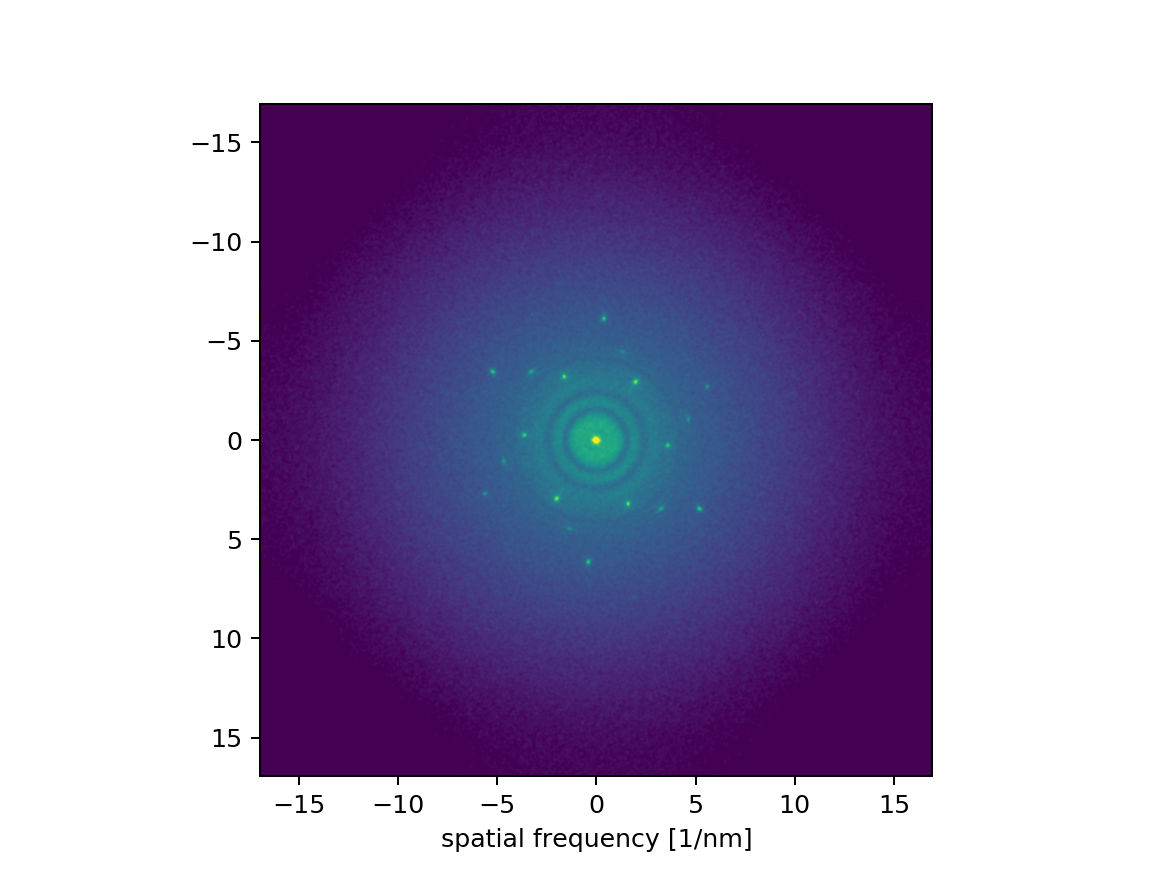

In [33]:
# We need some smoothing (here with a Gaussian)
smoothing = 3
fft_mag2 = ndimage.gaussian_filter(fft_mag, sigma=(smoothing, smoothing), order=0)


#prepare mask for low and high frequencies
pixels = (np.linspace(0,image.shape[0]-1,image.shape[0])-image.shape[0]/2)* rec_scale_x
x,y = np.meshgrid(pixels,pixels);
mask = np.zeros(image.shape)

mask_spot = x**2+y**2 > 2**2 
mask = mask + mask_spot
mask_spot = x**2+y**2 < 10**2 
mask = mask + mask_spot

mask[np.where(mask==1)]=0 # just in case of overlapping disks

fft_mag3 = fft_mag2*mask
print(np.std(fft_mag2),np.mean(fft_mag2) ,np.max(fft_mag2) )
#print(np.std(fft_mag2[np.where(mask==2)]),np.mean(fft_mag2[np.where(mask==2)]) ,np.max(fft_mag2[np.where(mask==2)]))


minimum_intensity = np.log2(.1+fft_mag2)[np.where(mask==2)].min()*0.95
#minimum_intensity = np.mean(fft_mag3)-np.std(fft_mag3)
maximum_intensity = np.log2(.1+fft_mag2)[np.where(mask==2)].max()*1.05
#maximum_intensity =  np.mean(fft_mag3)+np.std(fft_mag3)*2

print(minimum_intensity,maximum_intensity)
fig = plt.figure()
plt.imshow(np.log2(.1+fft_mag2).T, extent=rec_extend, origin = 'upper',vmin=minimum_intensity, vmax=maximum_intensity)
plt.xlabel('spatial frequency [1/nm]');


## Spot Detection

This diffractogram is now good enough to detect the spots with a blob detector.

Found 19 reflections


<IPython.core.display.Javascript object>


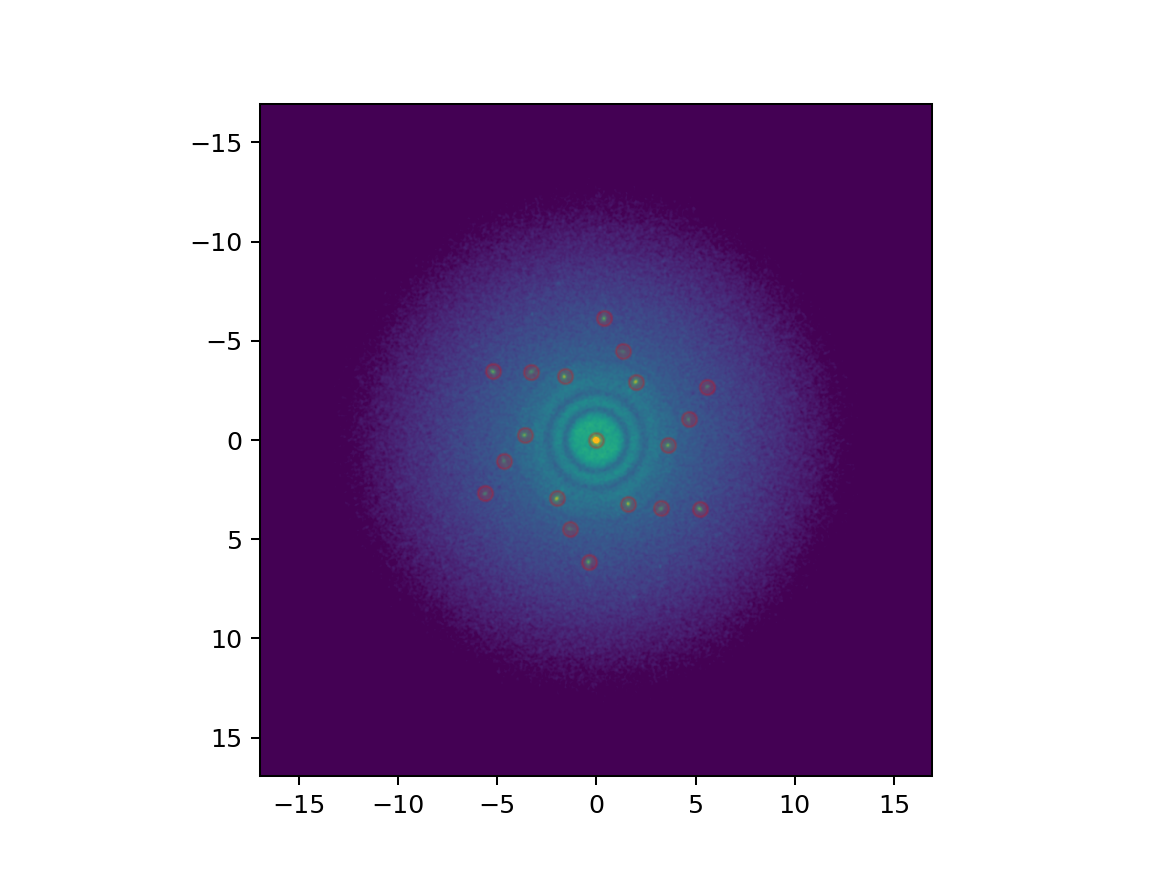

In [34]:
# Input
spot_threshold = 200000

## Needed for conversion from pixel to Reciprocal space
rec_scale = np.array([rec_scale_x, rec_scale_y,1])
center = np.array([int(image.shape[0]/2), int(image.shape[1]/2),1] )

fft_mag2 = ndimage.gaussian_filter(fft_mag, sigma=(smoothing, smoothing), order=0)
fft_mag2 = fft_mag2-fft_mag2.min()
#fft_mag2 = fft_mag2/fft_mag2.max()
## spot detection ( for future referece there is no symmetry assumed here)

spots_random =  (blob_dog(1+fft_mag2,  max_sigma= 5 , threshold=spot_threshold)-center)*rec_scale
print(f'Found {spots_random.shape[0]} reflections')
spots_random[:,2] = np.linalg.norm(spots_random[:,0:2], axis=1)
spots_index = np.argsort(spots_random[:,2])
spots = spots_random[spots_index]

## plot Fourier transform and found spots
fig = plt.figure()
plt.imshow( np.log2(1+fft_mag2).T, extent=rec_extend, origin = 'upper',vmin=minimum_intensity, vmax=maximum_intensity)

#vmin=fft_mag.min()*2.5, vmax=fft_mag.max()*.7)#, extent=(-1024*gx,1023*gx,1024*gy,-1023*gy))

plt.scatter(spots[:,0], spots[:,1], c='Red',  alpha = 0.2, label='spots');
#plt.xlim(-0.2,0.2)
#plt.ylim(-0.2,0.2);

## Adaptive Fourier Filtering

We mask the fourier transformed image so that the information can pass through is selected.

The information is in the spots and in the center of the Fourier transformed image, the rest is noise.

Please modify the radius of the mask of the **reflections** and the **low-pass** area in the code below and notice the effects on the Fourier filtered image.



<IPython.core.display.Javascript object>


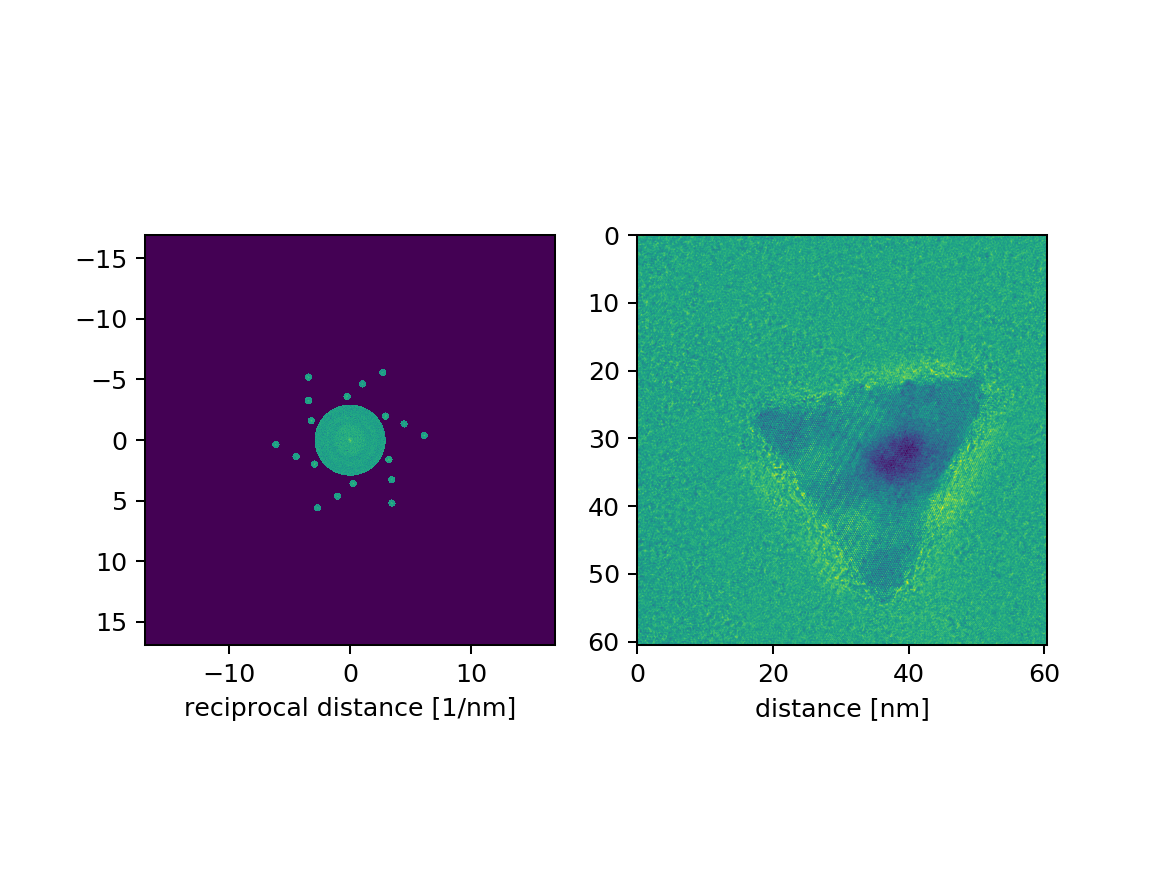

In [43]:
# Input 
reflection_radius = 0.3 # in 1/nm
low_pass = 1/.34 # in 1/nm diameter of mask for low pass filter


#prepare mask
pixels = (np.linspace(0,image.shape[0]-1,image.shape[0])-image.shape[0]/2)* rec_scale_x

x,y = np.meshgrid(pixels,pixels);
mask = np.zeros(image.shape)

# mask reflections
for spot in spots:
    mask_spot = (x-spot[0])**2+(y-spot[1])**2 < reflection_radius**2 # make a spot 
    mask = mask + mask_spot# add spot to mask
    
# mask zero region larger (low-pass filter = intensity variations)

mask_spot = x**2+y**2 < low_pass**2 
mask = mask + mask_spot

mask[np.where(mask>1)]=1 # just in case of overlapping disks

plt.figure()
ax1 = plt.subplot(1,2,1)
#ax1.imshow(mask)
fft_filtered = np.fft.fftshift(np.fft.fft2(image))*mask.T
ax1.imshow(np.log(1+np.abs(fft_filtered)).real,extent=rec_extend, origin = 'upper')
plt.xlabel('reciprocal distance [1/nm]')
ax2 = plt.subplot(1,2,2)
filtered = np.fft.ifft2(np.fft.fftshift(fft_filtered))

real_extent = (0,FOV_x,FOV_y,0)
    
ax2.imshow(filtered.real,extent=real_extent, origin = 'upper')
plt.xlabel('distance [nm]');


### Plot the image a bit bigger

<IPython.core.display.Javascript object>


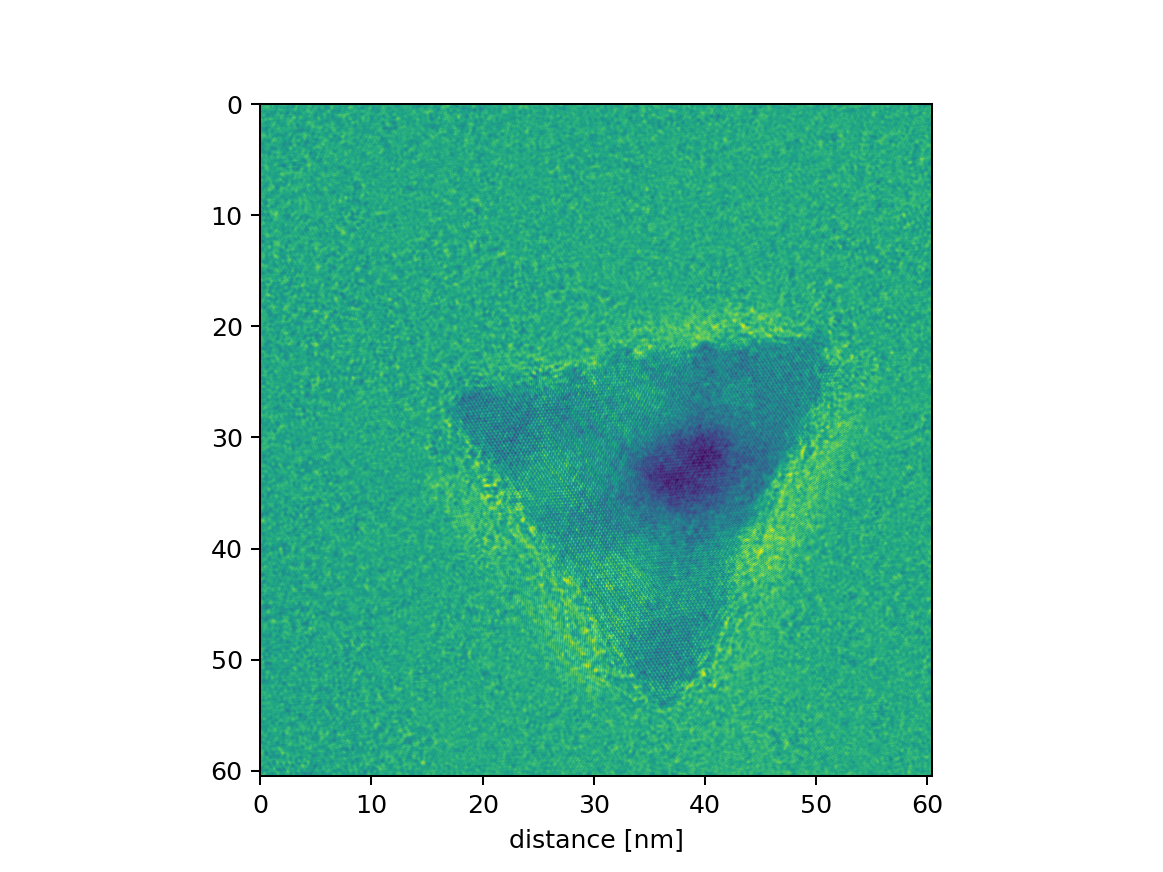

In [39]:
plt.figure()
plt.imshow(filtered.real, extent=real_extent, origin = 'upper')
plt.xlabel('distance [nm]');

## Check on filtered images

We don't want to filter anything out that caries information, or at least we want to be aware of that. 
An easy check is to subtract the filtered imag fromt he image and to determine that only noise is left.

Please note that any processing can be easily determined in the Fourier transformed, so be meticulous on reporting what you did to an image.


<IPython.core.display.Javascript object>


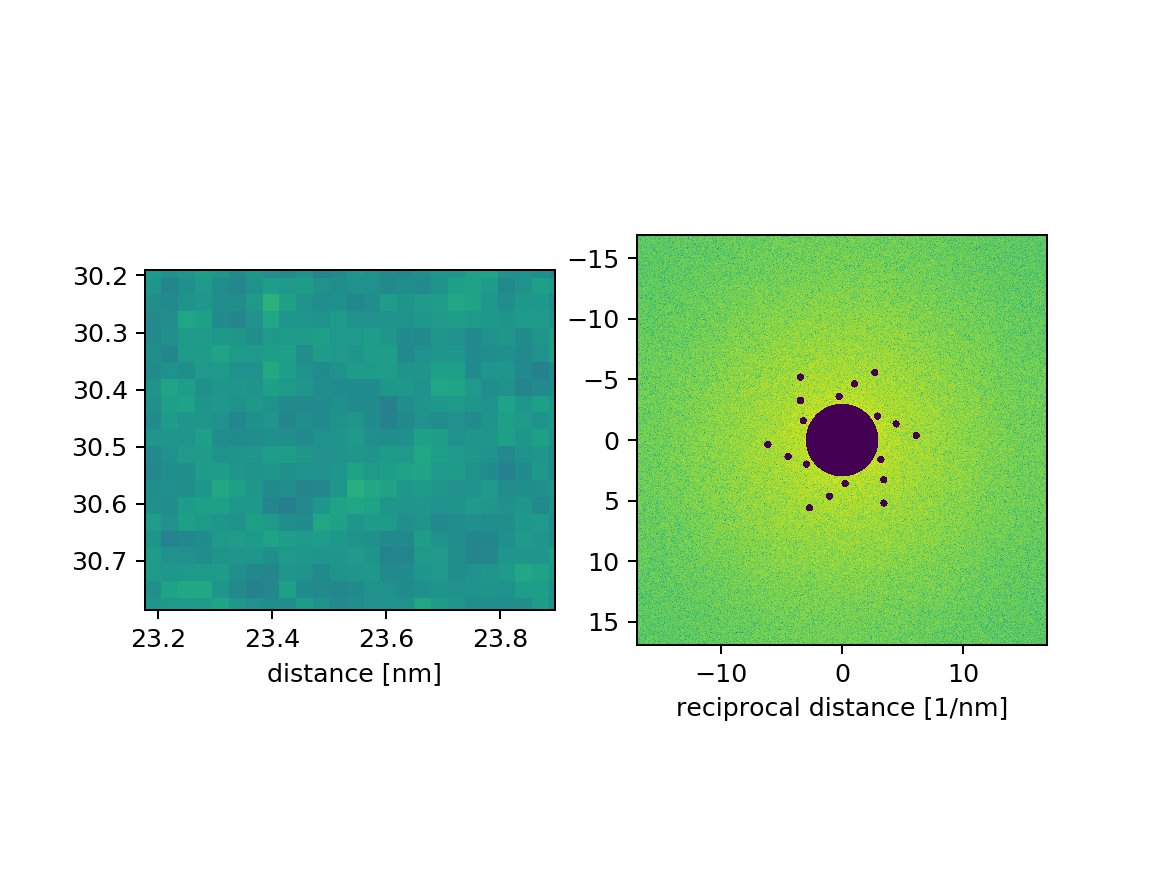

In [29]:
plt.figure()
ax1 = plt.subplot(1,2,1)
ax1.imshow(image-filtered.real,extent=real_extent, origin = 'upper')
plt.xlabel(' distance [nm]')

ax2 = plt.subplot(1,2,2)
fft_difference = np.fft.fftshift(np.fft.fft2(image-filtered.real))
ax2.imshow(np.log(1+np.abs(fft_difference)).real,extent=rec_extend, origin = 'upper')
plt.xlabel('reciprocal distance [1/nm]');

## Conclusion:

Fourier Transform is used to evaluate image quality and Fourier Filtering is used to eliminate high frequency noise.

If the computer is used to find the spots in the diffractogram, we do not have to select them ourselfs.
A carefull selection will,however, yield the same result.

## Back: [Diffraction](Diffraction.ipynb)
## Next: [Contrast Transfer Function](CTF.ipynb)
## Chapter 3: [Imaging](Imaging.ipynb)
## List of Content: [Front](_MSE672-IntroToTEM.ipynb)

# Appendix:  

For short code in notebook, use the Fourier_transform function in image_tools.

In [71]:
def Fourier_Transform(current_channel):
    tags = ft.get_dictionary_from_pyUSID(current_channel)
    
    sizeX
    image = tags['data']- tags['data'].min()
    fft_mag = (np.abs((np.fft.fftshift(np.fft.fft2(image)))))
    
    tags['fft'] = {}
    fft = tags['fft']
    fft['magnitude'] = fft_mag

    fft['analysis']= 'Fourier_Transform'

    fft['spatial_origin_x'] = data.shape[0]/2 # in pixels!
    fft['spatial_origin_y'] = data.shape[1]/2

    fft['spatial_scale_x'] = 1.0/current_channel['spatial_scale_x'][()]/data.shape[0]
    fft['spatial_scale_y'] = 1.0/current_channel['spatial_scale_x'][()]/data.shape[1]
    fft['spatial_size_x'] = data.shape[0]
    fft['spatial_size_y'] = data.shape[1]
    fft['spatial_units'] = '1/nm'


    FOV_x = fft['spatial_origin_x']* fft['spatial_scale_x']
    FOV_y = fft['spatial_origin_y']* fft['spatial_scale_y']
    fft['extent'] = [-FOV_x,FOV_x,FOV_y, -FOV_y]
    
    
    
    # We need some smoothing (here with a Gaussian)
    smoothing = 3
    fft_mag2 = ndimage.gaussian_filter(fft_mag, sigma=(smoothing, smoothing), order=0)


    #prepare mask for low and high frequencies
    pixels = (np.linspace(0,image.shape[0]-1,image.shape[0])-image.shape[0]/2)* rec_scale_x
    x,y = np.meshgrid(pixels,pixels);
    mask = np.zeros(image.shape)

    mask_spot = x**2+y**2 > 2**2 
    mask = mask + mask_spot
    mask_spot = x**2+y**2 < 10**2 
    mask = mask + mask_spot

    mask[np.where(mask==1)]=0 # just in case of overlapping disks

    fft_mag3 = fft_mag2*mask
    
    fft['magnitude_smooth'] = fft_mag2
    fft['minimum_intensity'] = np.log2(1+fft_mag2)[np.where(mask==2)].min()*0.95
    fft['maximum_intensity'] = np.log2(1+fft_mag2)[np.where(mask==2)].max()*1.05
    
    return tags 

## Usage of Function

<IPython.core.display.Javascript object>


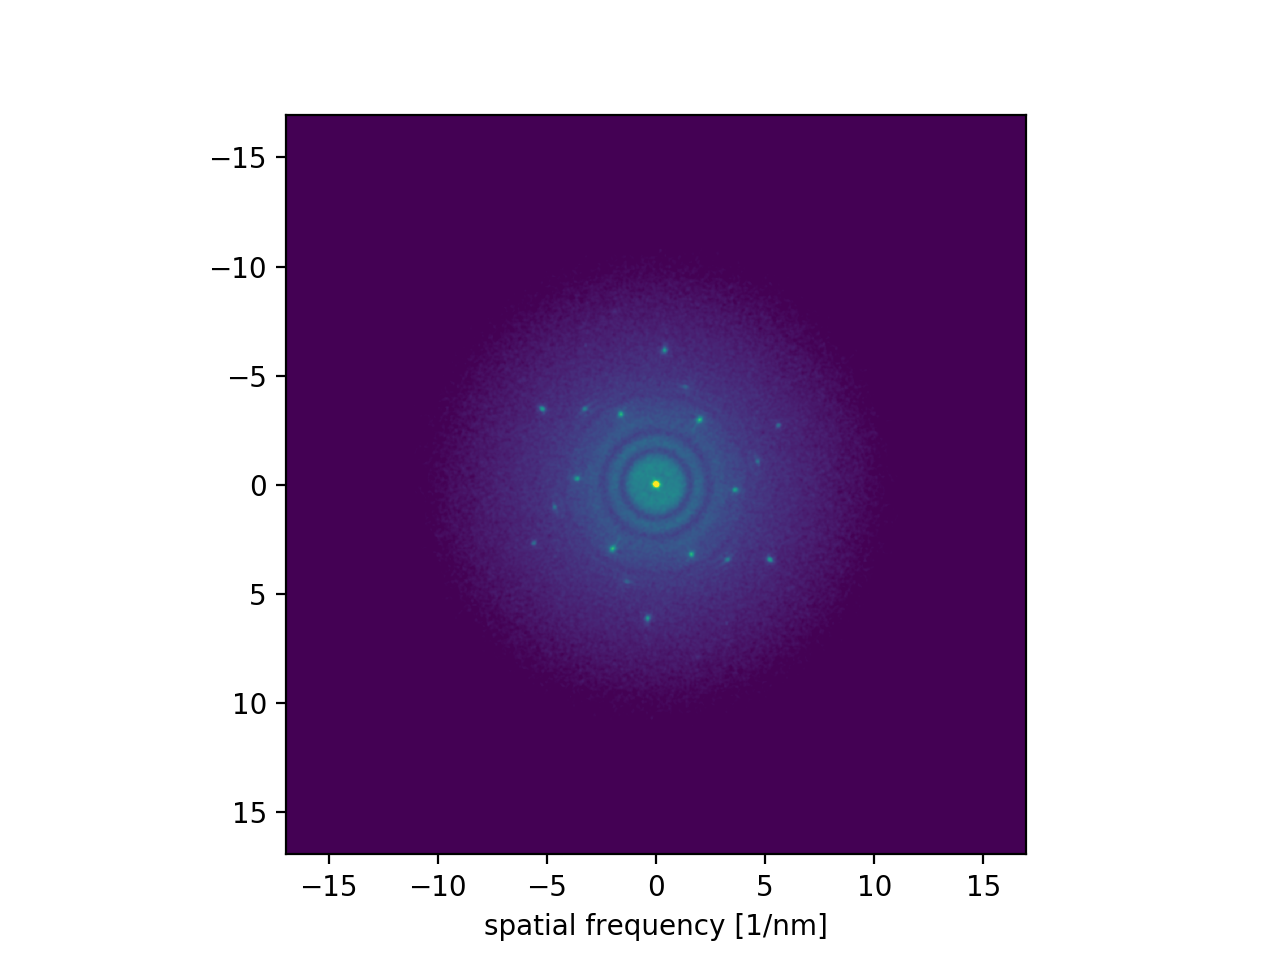

In [73]:
tags = Fourier_Transform(current_channel)
fft = tags['fft']    
fig = plt.figure()
plt.imshow(np.log2(1+ 0.5*fft['magnitude_smooth']).T, extent=fft['extent'], origin = 'upper',
           vmin=fft['minimum_intensity'], vmax=fft['maximum_intensity'])
plt.xlabel('spatial frequency [1/nm]');
   


# Log Fourier Transform

In [76]:
log_group = ft.h5_add_Log(current_channel, name='Fourier')
ft.h5_add_Data2Log(log_group, '', tags['fft'])


usid.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Log_000
      -------
      ├ _Fourier
      ├ time_stamp
      ├ title
    ├ Log_001
      -------
      ├ _Fourier
      ├ analysis
      ├ extent
      ├ magnitude
      ├ magnitude_smooth
      ├ maximum_intensity
      ├ minimum_intensity
      ├ spatial_origin_x
      ├ spatial_origin_y
      ├ spatial_scale_x
      ├ spatial_scale_y
      ├ spatial_size_x
      ├ spatial_size_y
      ├ spatial_units
      ├ time_stamp
      ├ title
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ data_type
    ├ original_metadata
      -----------------
    ├ spatial_origin_x
    ├ spatial_origin_y
    ├ spatial_scale_x
    ├ spatial_scale_y
    ├ spatial_size_x
    ├ spatial_size_y
    ├ spatial_units
    ├ title
